# Geomechanical Injection Scenario Toolkit (GIST)

#Disclaimer
GIST aims to give the _gist_ of a wide range of potential scenarios and aid collective decision making when responding to seismicity.

The results of GIST are entirely dependent upon the inputs provided, which may be incomplete or inaccurate.

There are other potentially plausible inducement scenarios that are not considered, including fluid migration into the basement, 
out-of-zone poroelastic stressing, or hydraulic fracturing.

None of the individual models produced by GIST accurately represent what happens in the subsurface and cannot be credibly used 
to accurately assign liability or responsibility for seismicity.

"All models are wrong, but some are useful" - George Box, 1976

## Prerequisites

Assumes GIST_RunTemplate has completed.

##Install Dependencies
- geopandas
- geodatasets
- matplotlib
- folium
- mapclassify
- contextily

In [0]:
%restart_python

In [0]:
%run "/Workspace/_utils/Utility_Functions"

In [0]:
!pip install geopandas
!pip install geodatasets
!pip install folium matplotlib mapclassify contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 123.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 104.0 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 5.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

##Paths

In [0]:
# Paths
homePath='/Workspace/Users/bill.curry@exxonmobil.com/'
# Injection data path 
injPath=homePath+'injection/WeeklyRun/ScheduledOutput/'
# GIST library path
gistPath=homePath+'GIST/'

##Libraries

- os
- numpy
- scipy
- pandas
- matplotlib
- geopandas
- pyspark
- seaborn
- contextily
- gistPlots
- gistMC
- eqSQL


In [0]:
import sys
sys.path.append(gistPath)
sys.path.append(gistPath+'lib')

In [0]:
import numpy as np
import pandas as pd
import os
import gistMC as gi
import eqSQL as es
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import contextily as cx
import gistPlots as gp

#1. Select Event

In [0]:
eventID='texnet2024oqfb'

In [0]:
runPath=gistPath+'/runs/'+eventID+'/'
EQDF=pd.read_csv(runPath+'/EQ.csv')
EQDF=geopandas.GeoDataFrame(EQDF, geometry=geopandas.points_from_xy(EQDF['Longitude'],EQDF['Latitude']), crs="EPSG:4326")

   Unnamed: 0  SeismicEventId                 DataSource  ...  Strike   Dip  Rake
0           0         2481836  TexNet Earthquake Catalog  ...    80.0  55.0 -85.0

[1 rows x 39 columns]
(-102.00521400000001, -101.605214)


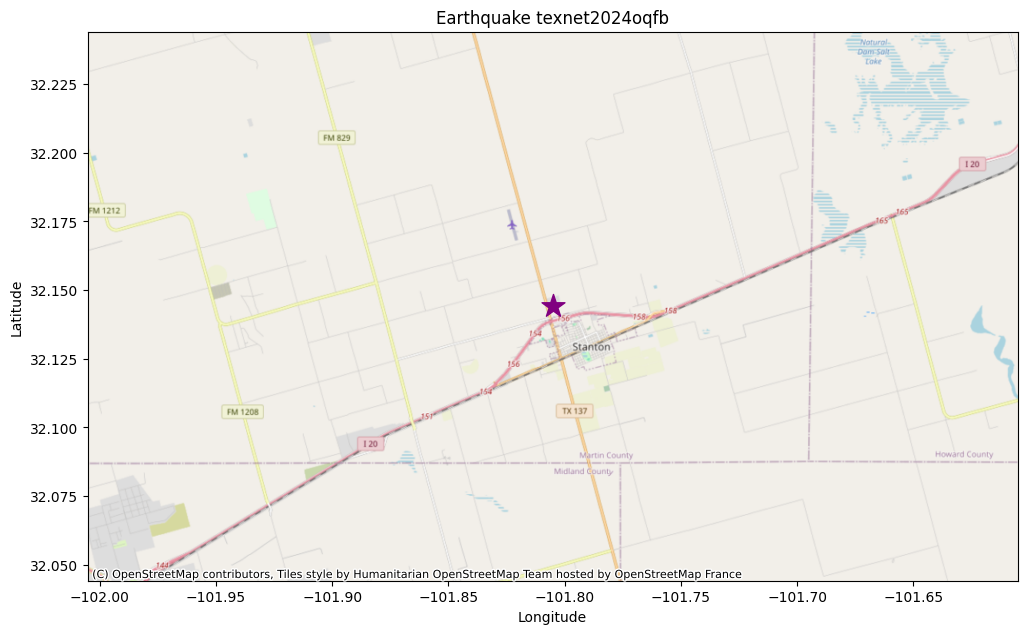

In [0]:
# Should we include nearby seismicity?
zoomx=0.2
zoomy=0.1
print(EQDF)
fig, ax = plt.subplots(figsize=(12,12))
plt.title('Earthquake '+EQDF['EventID'][0])
EQDF.plot(ax=ax,color='purple',marker='*',markersize=300)
xlim=(EQDF['Longitude'][0]-zoomx,EQDF['Longitude'][0]+zoomx)
ylim=(EQDF['Latitude'][0]-zoomy,EQDF['Latitude'][0]+zoomy)
print(xlim)
plt.xlim(xlim)
plt.ylim(ylim)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
cx.add_basemap(ax,zoom=12,crs="EPSG:4326")
plt.show()

#2. Initial Run

In [0]:
# Binary deep/shallow parameter
deepOrShallow='Deep'
runIntervalPath=runPath+deepOrShallow+'/'

In [0]:
if deepOrShallow=='Deep':
  WellFile=injPath+'/deep.csv'
  InjFile=injPath+'/deepReg.csv'
  OutOfZoneWellFile=injPath+'/shallow.csv'
elif deepOrShallow=='Shallow':
  WellFile=injPath+'/shallow.csv'
  InjFile=injPath+'/shallowReg.csv'
  OutOfZoneWellFile=injPath+'/deep.csv'

In [0]:
allInZoneWellsDF=pd.read_csv(WellFile)
allOutOfZoneWellsDF=pd.read_csv(OutOfZoneWellFile)
RTDF=pd.read_csv(runIntervalPath+'RTDF.csv')
WellsRTDF=pd.read_csv(runIntervalPath+'RTwells.csv')

## Subsurface Property Histograms

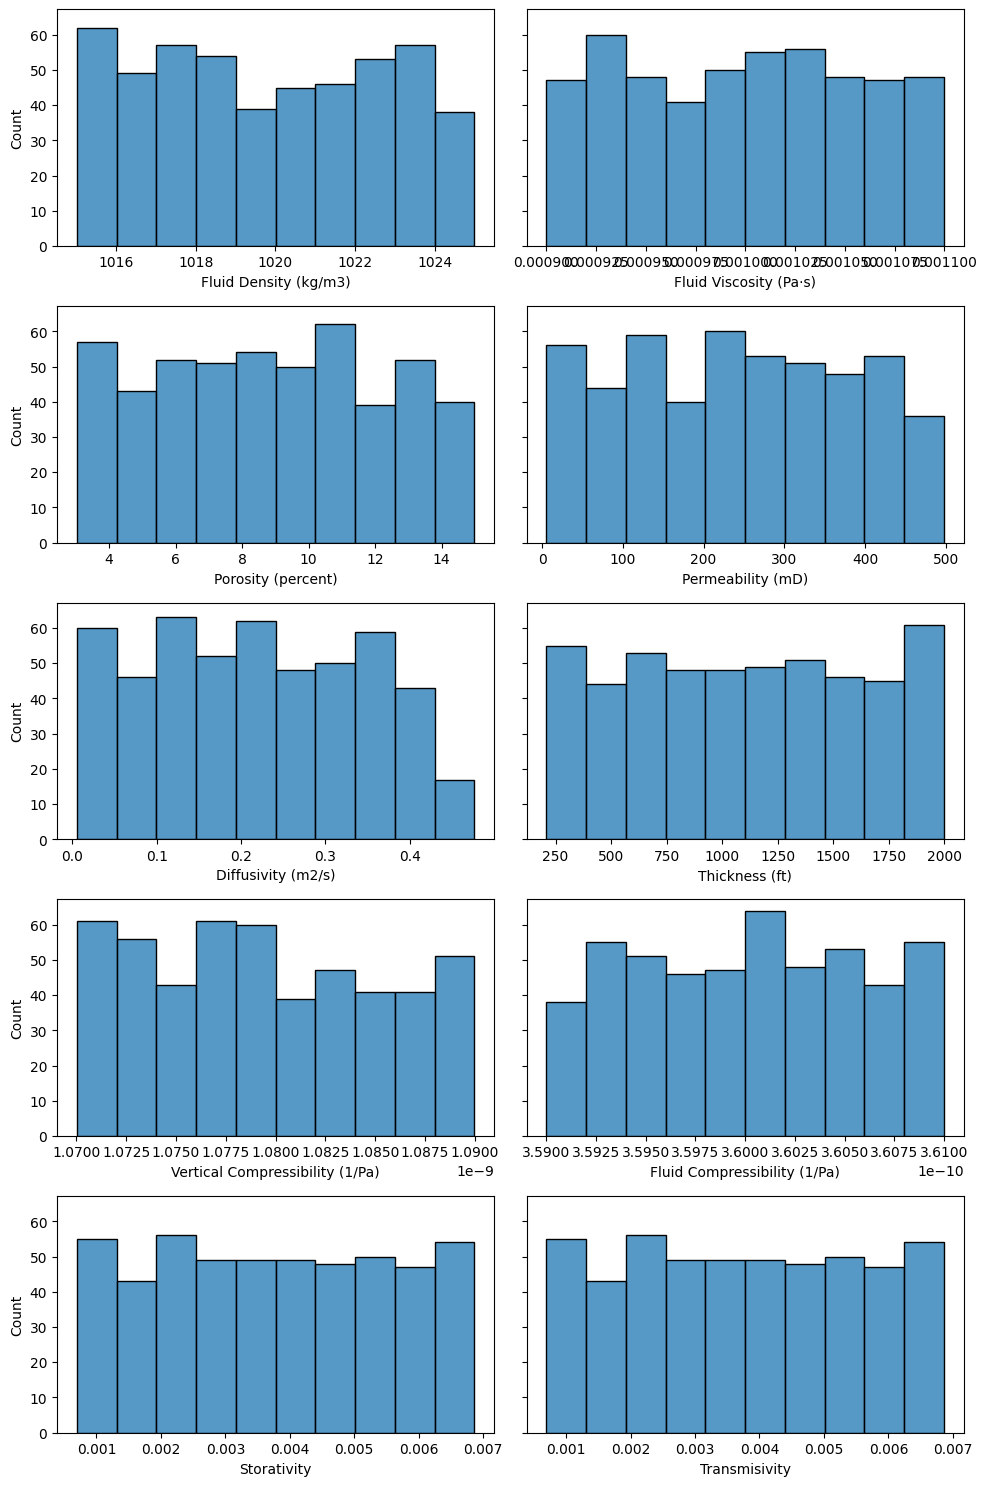

In [0]:
realizationsDF=pd.read_csv(runIntervalPath+'PorePressureRealizations.csv')
gp.histogramMCPP(realizationsDF)

## R-T Well Selection Plots

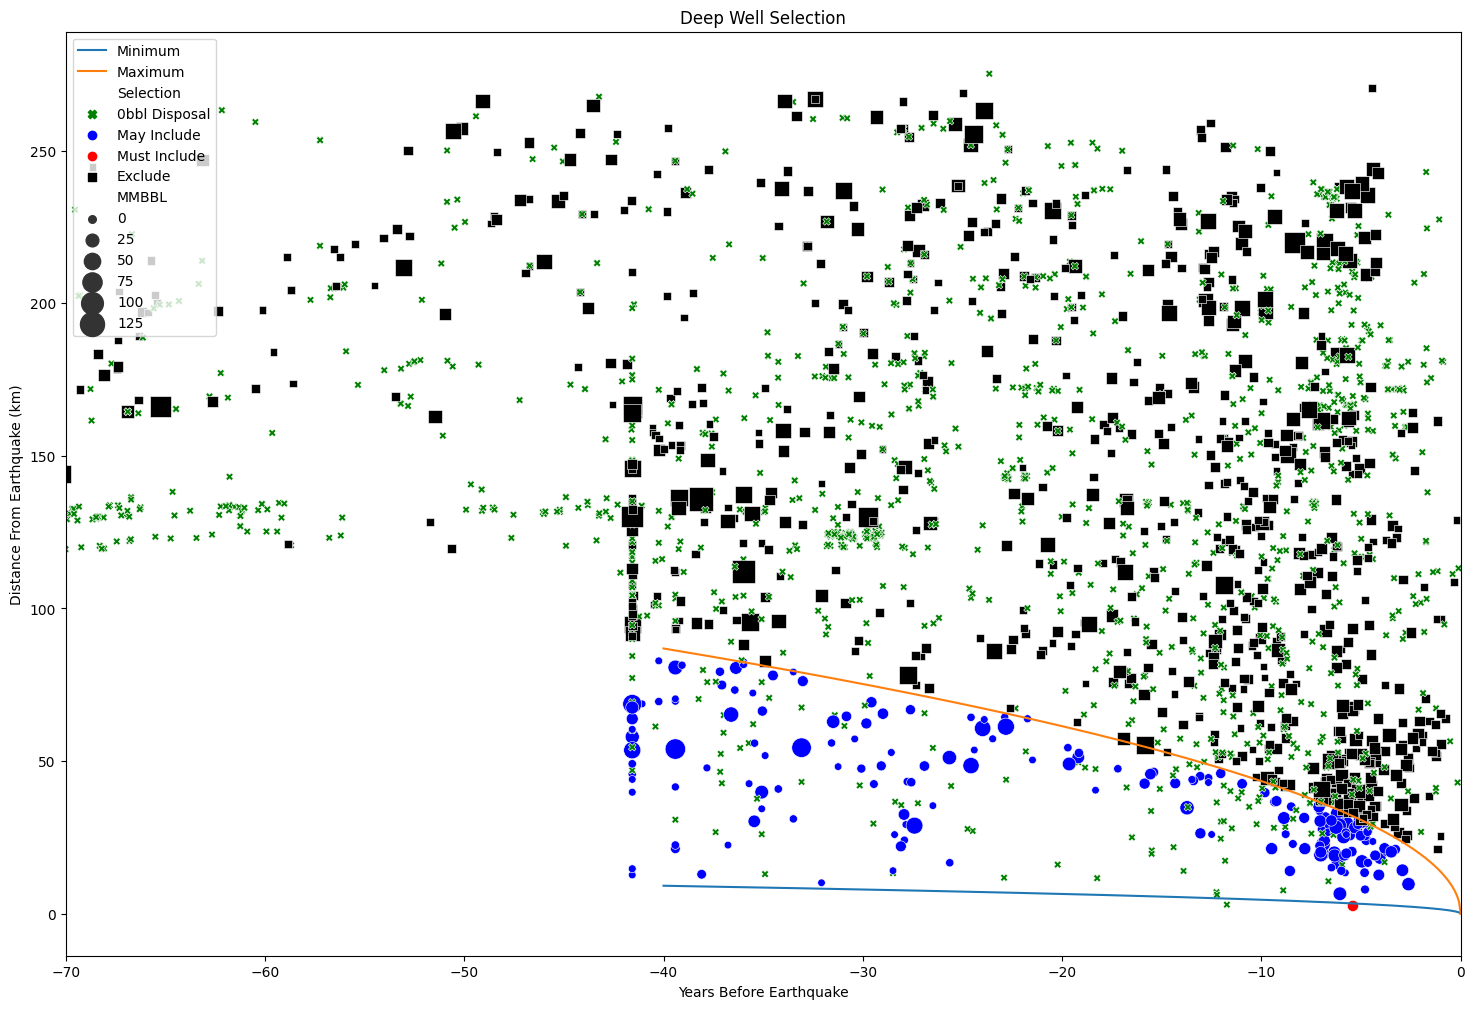

In [0]:
gp.rMinusTPlotPP(WellsRTDF,RTDF,minYear=-70,sizeTuple=(30,300),title=deepOrShallow+' Well Selection',zoom=False)

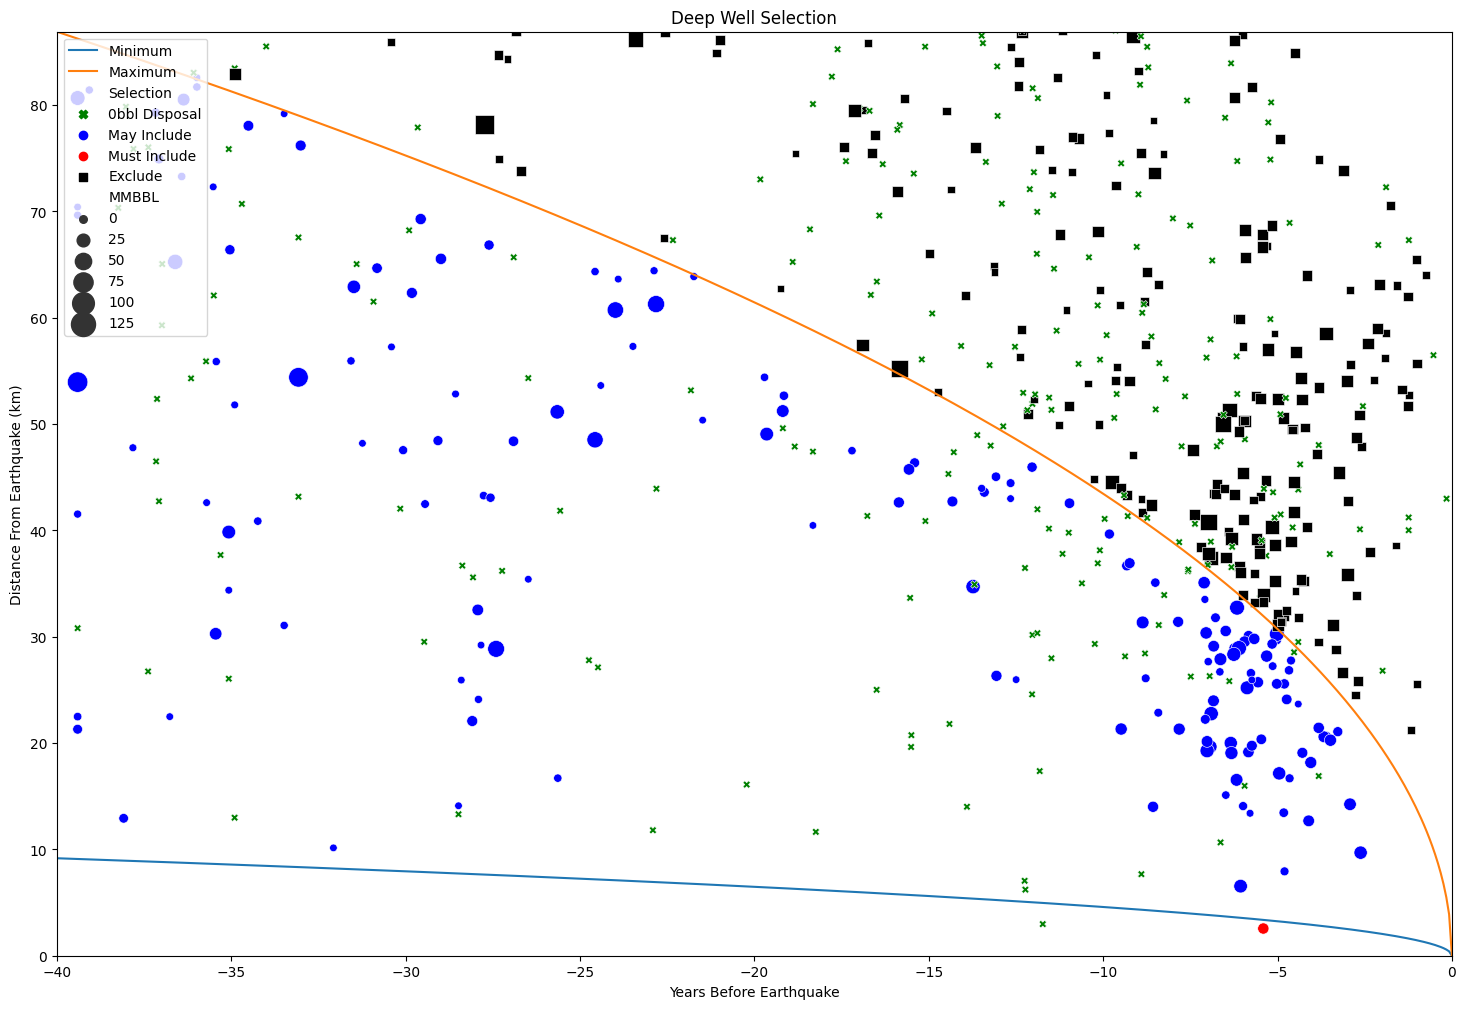

In [0]:
gp.rMinusTPlotPP(WellsRTDF,RTDF,minYear=-40,sizeTuple=(30,300),title=deepOrShallow+' Well Selection',zoom=True)

##Well Selection Maps

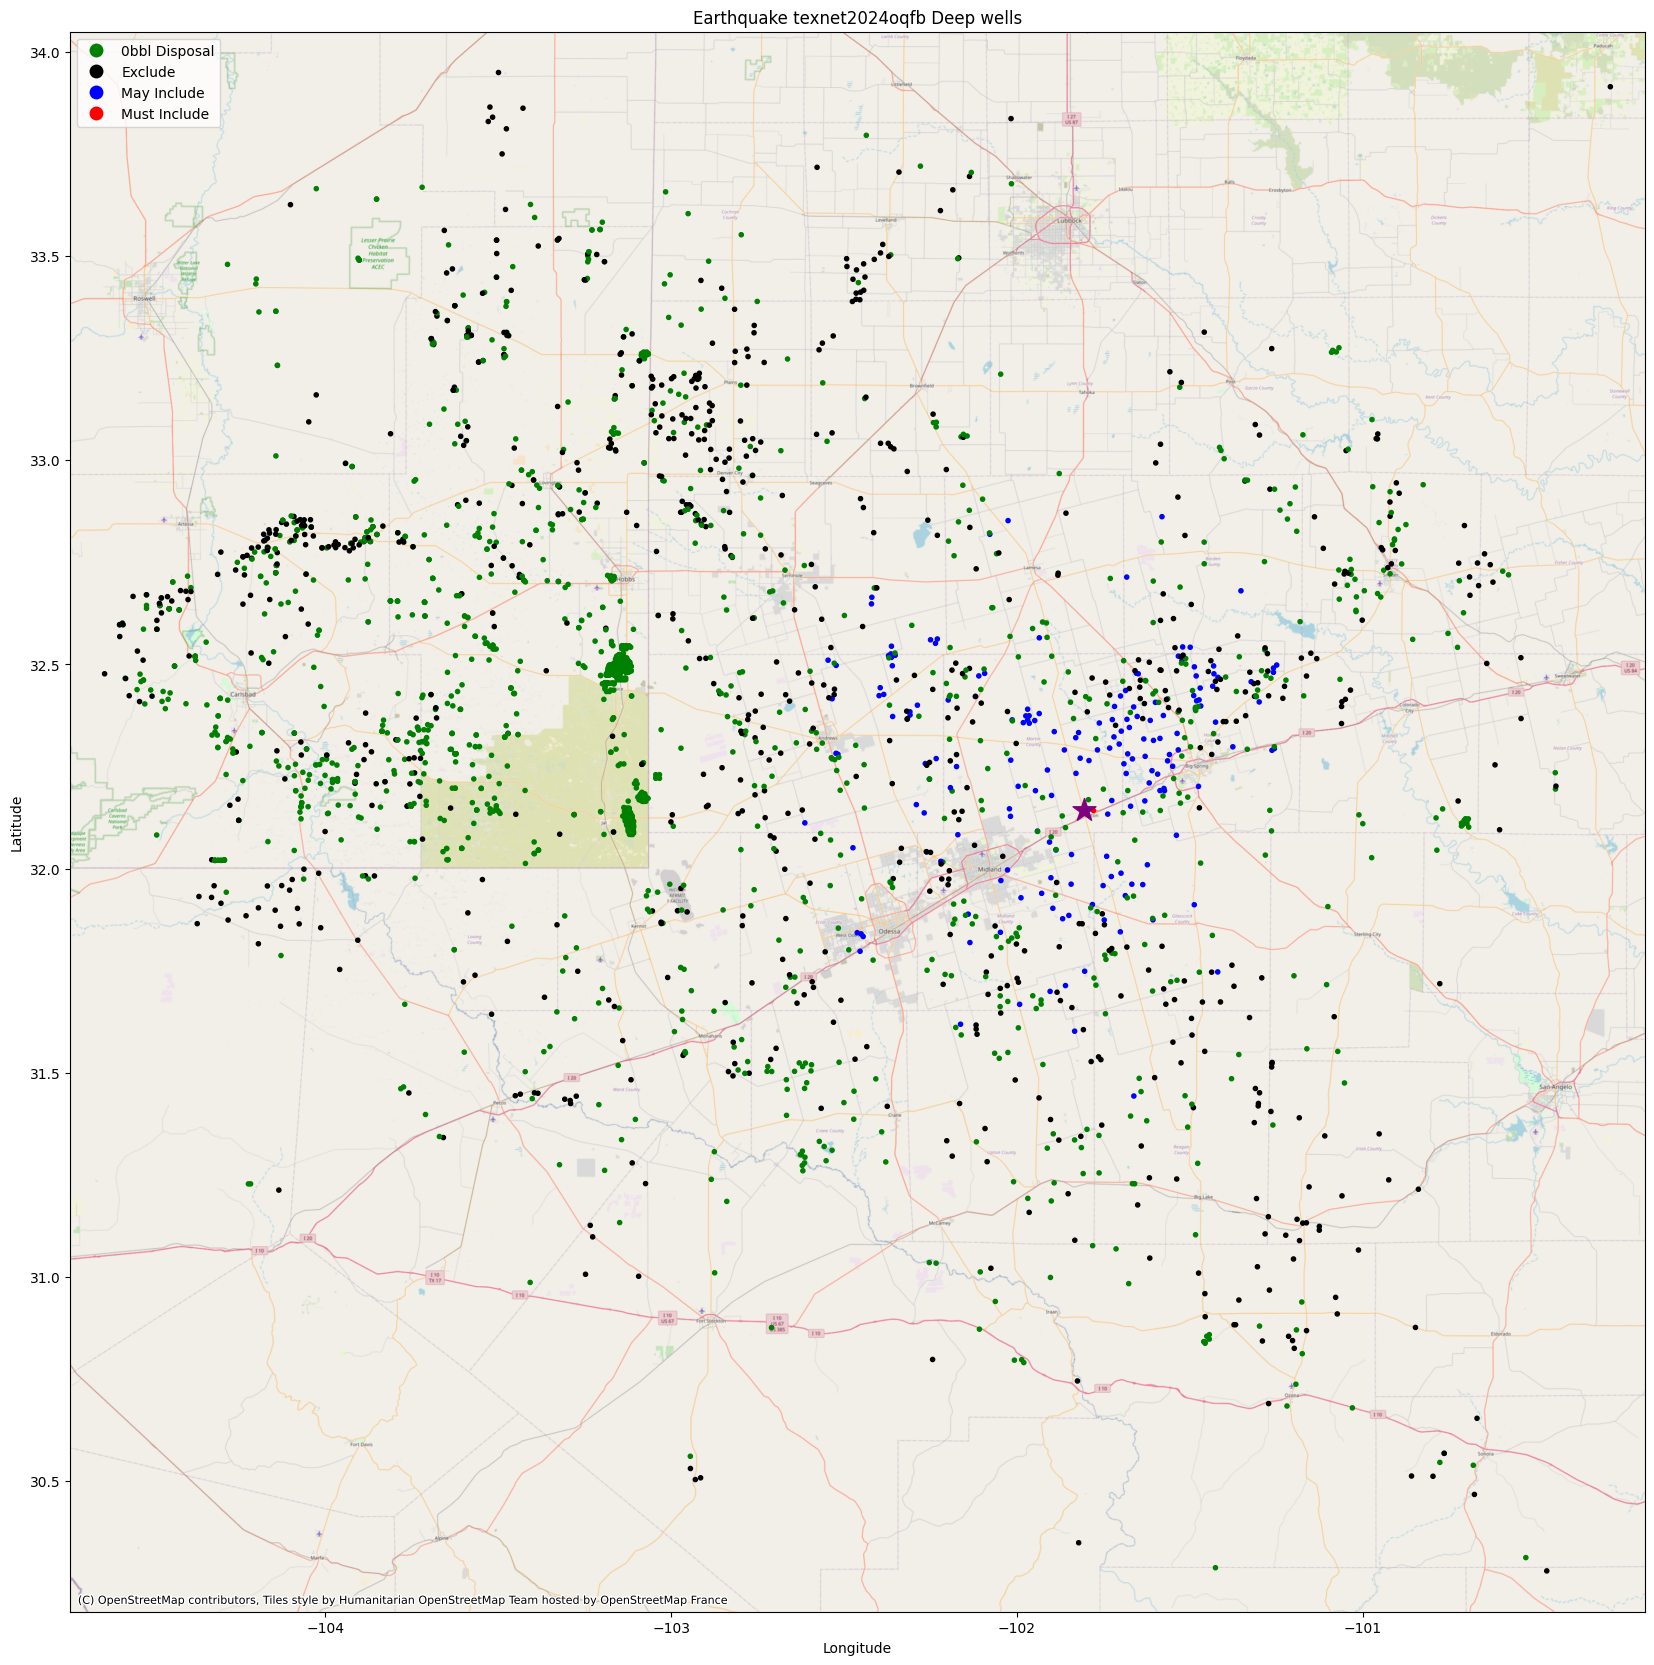

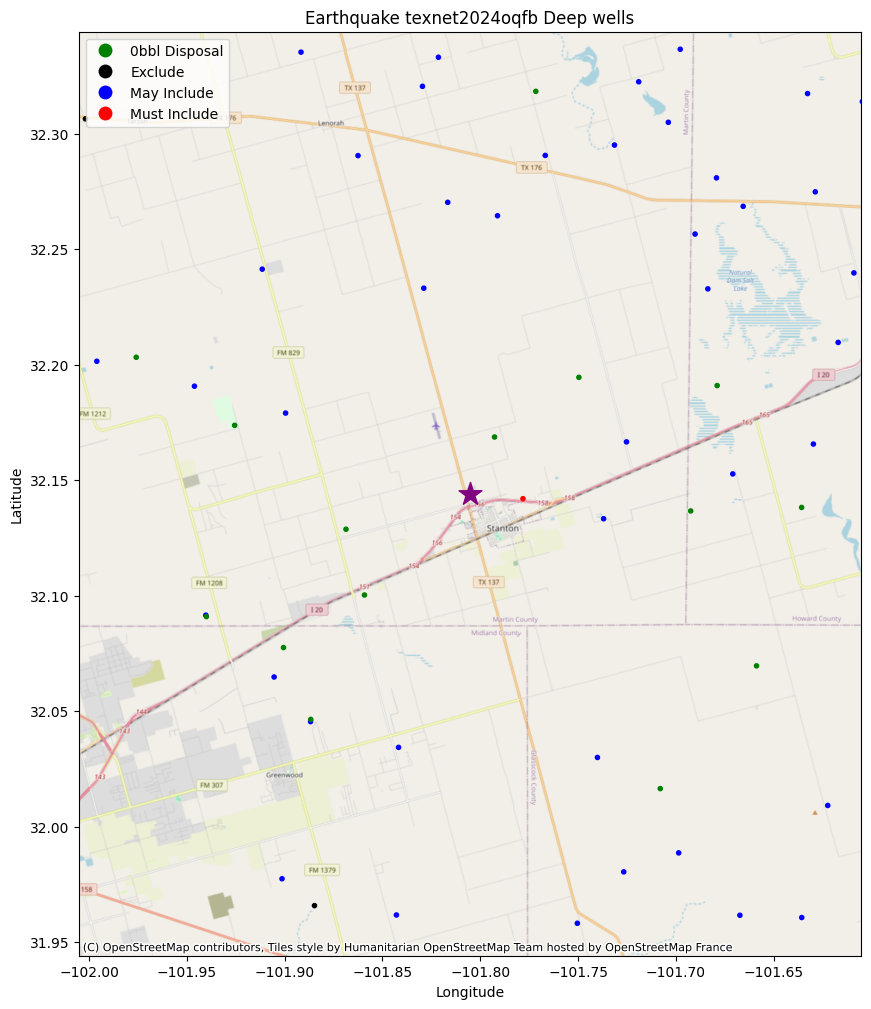

In [0]:
gp.intervalWellMapPP(EQDF,deepOrShallow,WellsRTDF)
gp.intervalWellMapPP(EQDF,deepOrShallow,WellsRTDF,zoom=0.2)# Map of selected wells and in-zone wells
# Table of corresponding information

In [0]:
displayColumns=['Distances','ID','APINumber','WellName','WellNumber','Operator','PermittedMaxLiquidBPD','StartDate']
print("Must-include wells:")
display(WellsRTDF[WellsRTDF['Selection']=='Must Include'][displayColumns].sort_values('Distances'))
print("May-include wells:")
display(WellsRTDF[WellsRTDF['Selection']=='May Include'][displayColumns].sort_values('Distances'))
print("Wells with no in-zone disposal within 50km:")
display(WellsRTDF[(WellsRTDF['Selection']=='0bbl Disposal') & (WellsRTDF['Distances']<50.)][displayColumns].sort_values('Distances'))
print("Excluded wells within 50km:")
display(WellsRTDF[(WellsRTDF['Selection']=='Exclude') & (WellsRTDF['Distances']<50.)][displayColumns].sort_values('Distances'))

Must-include wells:


Distances,ID,APINumber,WellName,WellNumber,Operator,PermittedMaxLiquidBPD,StartDate
2.558174400264295,2121094,42-317-41652,MARIENFELD 13 1D,1D,PIONEER NATURAL RESOURCES,30000.0,2019-03-01


May-include wells:


Distances,ID,APINumber,WellName,WellNumber,Operator,PermittedMaxLiquidBPD,StartDate
6.542261331370596,2121271,42-317-41325,ANNALEA SWD 1,1,SM ENERGY,35000.0,2018-07-06
7.934466562017759,2114817,42-317-42432,SALT LAKE SWD 1,1,OVERFLOW ENERGY PERMIAN,30000.0,2019-10-09
9.69368840138171,2123938,42-317-43701,PALO VERDE 1,1,STONEHILL MARTIN,40000.0,2021-12-14
10.145073709797517,2072223,42-317-32928,"SUPERIOR STRAIN \""-SWD- 1D",1D,WALSH & WATTS,4000.0,1992-07-01
12.684394410659095,2117885,42-227-40294,FAUDREE 1D,1D,"OXYROCK OPERATING, LLC",25000.0,2020-06-18
12.690632722359036,2018967,42-329-01297,MASHBURN 2,2,STEPHENS AUTRY C,1000.0,1983-01-01
12.92314260135016,2056720,42-329-31484,PENROSE-OLDHAM SWD 2,2,DE IV OPERATING,7500.0,1986-06-26
13.397749546353452,2119799,42-329-42355,"EPLEY, L.B. 18D",18D,RATTLER MIDSTREAM OPERATING,40000.0,2018-10-13
13.450778071467187,2113898,42-317-41765,DAGGER LAKE SWD 08SD,08SD,XTO ENERGY,25000.0,2019-10-01
14.00767414998453,2109094,42-317-40301,DICKENSON 20 8D,8D,DEEP BLUE OPERATING,50000.0,2016-01-01


Wells with no in-zone disposal within 50km:


Distances,ID,APINumber,WellName,WellNumber,Operator,PermittedMaxLiquidBPD,StartDate
2.974654557369253,2119388,42-317-00104,"FLANAGAN, ANNIE OIL MANAGEMENT 1",1,ARYA RESOURCES,4000.0,2012-11-02
6.215716220020589,2100217,42-317-00172,"MCADAMS, GARNER 2",2,DIAMONDBACK E&P,6000.0,2012-05-04
7.047485191377316,2100192,42-317-00173,"YATER, MILT 1",1,DIAMONDBACK E&P,6000.0,2012-04-26
7.6698527693483936,2118838,42-317-34586,ALLAR 45 2,2,COBRA O&G,3000.0,2015-09-01
10.65664585698369,2111437,42-227-37594,"HOOPSNAKE \""23\"" 2",2,SM ENERGY,30000.0,2017-12-08
11.646152275655137,2092926,42-329-31249,PENROSE-OLDHAM 4,4,SELECT WATER SOLUTIONS,10000.0,2006-05-01
11.803007564394914,2088016,42-317-32854,YATER SWD 2W,2W,ENVIRONMENTAL DISPOSAL SYSTEMS,30000.0,2001-08-29
12.98292881116933,2067332,42-227-34379,1WD,1WD,FASKEN BARBARA,500.0,1989-08-31
13.30496168006024,2079881,42-329-31571,"EPLEY, L. B. 8D",8D,DEEP BLUE OPERATING,20000.0,1996-02-01
14.012019566988023,2120442,42-317-34301,"DICKENSON \""20\"" 3WD",3WD,DEEP BLUE OPERATING,12000.0,2010-08-31


Excluded wells within 50km:


Distances,ID,APINumber,WellName,WellNumber,Operator,PermittedMaxLiquidBPD,StartDate
21.204949408933807,2128440,42-329-45396,MIGHTY MO #1 SWD 1,1,ENVIRONMENTAL DISPOSAL SYSTEMS,20000.0,2023-05-26
24.52438111523632,2123968,42-317-43455,HUGHES 44 SWD 1,1,ENVIRONMENTAL DISPOSAL SYSTEMS,24500.0,2021-10-18
25.56432306668502,2117915,42-329-45398,ELKINS ATRELLA AWD 1,1,ENVIRONMENTAL DISPOSAL SYSTEMS,50000.0,2023-07-24
25.848908976665257,2123921,42-317-43781,TOUCAN SWD 11R,11R,ENVIRONMENTAL DISPOSAL SYSTEMS,20000.0,2021-11-15
26.680631287277517,2117806,42-317-42746,POSEIDON SWD 1,1,ENVIRONMENTAL DISPOSAL SYSTEMS,30000.0,2021-06-09
28.796594376878776,2126653,42-173-38366,WRAGE 21 4D,4D,"OXYROCK OPERATING, LLC",15000.0,2021-04-01
29.49193131055142,2123448,42-227-40609,COTTONMOUTH 1D,1D,DEEP BLUE OPERATING,38880.0,2020-10-01
31.079879777948605,2126775,42-329-44656,ERLENMEYER 1D,1DR,"OXYROCK OPERATING, LLC",30000.0,2021-03-01
31.088582028177445,2116406,42-329-43241,HYDROXIDE 1D,1D,"OXYROCK OPERATING, LLC",25000.0,2019-08-01
31.400334446341123,2112378,42-227-39562,TUBB SWD 1D,1D,"OXYROCK OPERATING, LLC",10000.0,2019-09-01


In [0]:
# Map
# Table

##Pressure disaggregation plots

 disaggregationPlotPP: figure height is  10.0


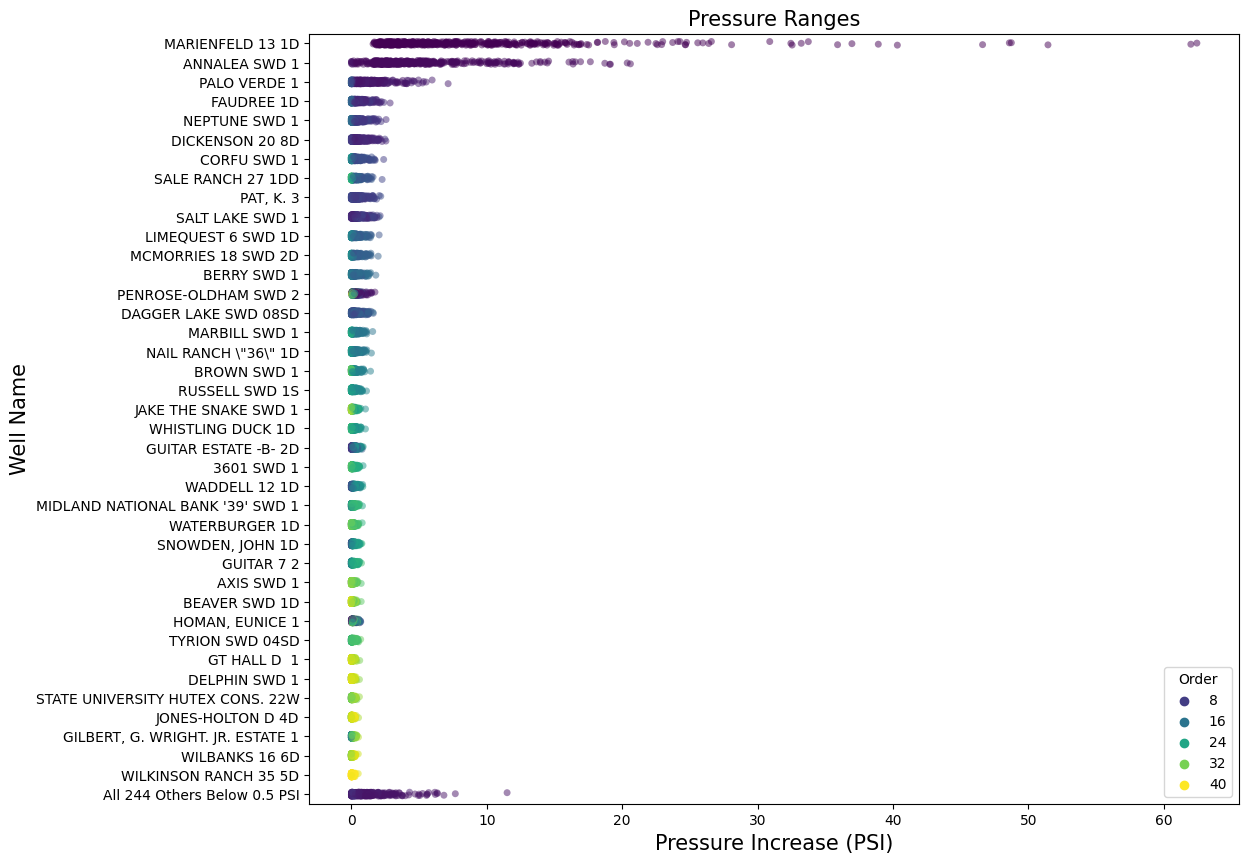

In [0]:
summaryPPDF=pd.read_csv(runIntervalPath+'filteredScenarios.csv')
wellOrder=pd.read_csv(runIntervalPath+'wellOrder.csv')['Name'].values
gp.disaggregationPlotPP(summaryPPDF,wellOrder,deepOrShallow+' Pressure Ranges',verbose=2)

##Pressure Time Series

#3. Correct Data

##Tables of Output Well Information

##Tables of Uploaded Well Information

#4. Updated Analysis

#5. Forecast